In [35]:
import random
import numpy as np
import matplotlib
import numba
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

### NOTEBOOK 3
### Indhold: 
Oprindelige Prisoner's dilemma, en npc_player, en 2nd generation npc player der undercutter efter 3 Coop, og så går den tilbage så snart den bliver straffet \
PLUS hardcodet NPC 
Almindelig Q-learner, master Q-learner \
Intet master-theta eller epsilon ændring over generationer

In [237]:
#random.seed(1235)
#Demand function from Klein (2020)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(3,3), (0,5)],
            [(5,0), (1,1)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [238]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[t,:,p2]))
    return p3

In [239]:
#Tit 4 Tat
@njit
def tft_player(options, q_table, epsilon, prev_q, prev_npc, iq_counter, jnpc_counter):
    tft_choice = int(prev_q[iq_counter-1])
    return tft_choice

In [240]:
# Pavlov, 2 CC - C else 1
@njit
def npc_player(options, q_table, epsilon, prev, time):
    if prev[time-1]==0 and prev[time]==0:
        npc_choice = 0
    else:
        npc_choice = 1
    return npc_choice

In [241]:
#NPC: Undercut after 3 Coop
@njit
def npc_player_gen2(options, q_table, epsilon, prev_q, prev_npc, iq_counter, jnpc_counter):
    if prev_q[iq_counter-3] ==0 and prev_q[iq_counter-2]==0 and prev_q[iq_counter-1]==0:
        npc_choice = 1
        #print('Choices', prev_q, prev_npc, iq_counter, jnpc_counter)
    elif prev_q[iq_counter-4] ==0 and prev_q[iq_counter-3]==0 and prev_q[iq_counter-2]==0:
        #print(prev_npc[jnpc_counter-1])#int(prev_q[iq_counter-1])==0 and prev_npc[jnpc_counter-1]==1:
        
        npc_choice = 0
        #print('CASE')
    else:
        #print('tit4tat')
        npc_choice = int(prev_q[iq_counter-1])
    return npc_choice

In [242]:
# tit4tat till 1/2 then GRIM TRIGGER PLAYER 
@njit
def npc_player_gen3(periods, prev_q, prev_npc, iq_counter, jnpc_counter):
    if jnpc_counter < int(periods/4):
        npc_choice = int(prev_q[iq_counter-1])
    else:
        if np.any(prev_q[int(periods/4):]== 1):
            npc_choice = 1
        else:
            npc_choice = 0

    return npc_choice

In [243]:
# tit4tat till 1/2 and then Pavlov PLAYER after halfway
@njit
def npc_player_gen4(periods, prev_q, prev_npc, iq_counter, jnpc_counter):
    if jnpc_counter < int(periods/4):
        npc_choice = int(prev_q[iq_counter-1])
    elif prev_q[iq_counter-2]==0 and prev_q[iq_counter-1]==0:
        npc_choice = 0
    else:
        npc_choice = 1
    return npc_choice

In [244]:
# Tit for tat for two tats PLAYER
@njit
def npc_player_gen5(periods, prev_q, prev_npc, iq_counter, jnpc_counter):
    if jnpc_counter < int(periods/4):
        npc_choice = int(prev_q[iq_counter-1])
    elif prev_q[iq_counter-2]==1 and prev_q[iq_counter-1]==1:
        npc_choice = 1
    else: 
        npc_choice = 0
    return npc_choice

In [245]:
test = np.array([0,0,0,0,0,0,0])
print(test==1)
np.any(test[5:]==1)

[False False False False False False False]


np.False_

In [246]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
     if indic == 1: 
         p1 = prev[0,0]
         p2 = prev[1,0]
         p22 = prev[1,1]
         pe1 = Q[prev[0,0],prev[1,0]]
         ne1 = PD_rewards(p1,p2)[0] + delta* PD_rewards(p1,p22)[0] + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
         Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
     else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]

        ne2 = PD_rewards(p2,p1)[1] + delta* PD_rewards(p22,p1)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [230]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, previous_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        
        # Current_t = numba.int64(np.floor(time/interval_size))
        # previous_t = numba.int64(np.floor((time-1)/interval_size))
                
        #print('indices',prev[0,0],prev[1,0],prev_time)
        #print('prices', my_old_price, their_new_choice, their_old_price)
        prev_q_est = Q[previous_t, prev[0,0],prev[1,0]]
        #print('PD_reward', PD_rewards(my_old_price,their_old_price))
        #print('argmax i Q', Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]])
        #print("PREV", prev[0,1])
        
        
        
        new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]]
        #print("New Q est", new_q_est)
        prev_interval = max(0,Current_t-1)
        next_interval = min(intervals-1, Current_t+1)
        
        #print("operation",(time/interval) - Current_t)
        #if (time/interval) - Current_t < 0.5:
        #        prev_w = 0.5 - abs((time/interval) - prev_interval )
        #        curr_w = 1-prev_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])
        #else:
        #        next_w = 0.5 - abs((time/interval) - next_interval) 
        #        curr_w = 1-next_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]])


        w_1 =  ( next_interval - time/interval) / (next_interval - prev_interval)
        w_2 =  (time/interval - prev_interval) / (next_interval-prev_interval) 
        #print('VÆGTE!!!:', w_1, w_2) 
        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (w_2 * new_q_est + w_1 * Q[next_interval, prev[0,0], prev[1,0]])
        #curr_w = 1-prev_w
        #Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]] + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])

In [318]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta, master_theta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    Simple_Q_Table2 = np.zeros((a, a))
    interval_size = periods/15
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (15,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            master_epsilon = (1-master_theta)**t
            if t % 2 != 0: 
                time_for_q = int(np.floor(t/interval_size))
                prev_time_for_q = int(np.floor((t-1)/interval_size))
                #print("TimeCHeck",time_for_q,time_for_q)
                #print('time for q', time_for_q, 'prev time for q', prev_time_for_q, "prev", prev_choices)
                update(q_table, prev_choices, alpha, delta, options, time_for_q, prev_time_for_q, t, interval_size)
                p_i =int(master_q_player(options, q_table, master_epsilon, prev_choices[1,1], time_for_q))
                #In Case of Q opponent:
                #regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 1)
                #p_i = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[1,1])
                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = int(options[p_i])
                i_counter += 1
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 
                #In Case of Q opponent:
                #egular_update(Simple_Q_Table2, prev_choices, alpha, delta, options, 2)
                #p_j = simple_Q_learner(options, Simple_Q_Table2, epsilon, prev_choices[0,1])
                #a hard coded opponent: 
                #p_j= npc_player(options, q_table, 0, all_choices1,j_counter)
                #p_j = int(npc_player_gen2(options, q_table, 0, all_choices1, all_choices2, j_counter, i_counter))
                p_j = int(npc_player_gen3(periods, all_choices1, all_choices2,i_counter,j_counter))
                #p_j = int(npc_player_gen4(periods, all_choices1, all_choices2,i_counter,j_counter))
                #p_j = int(npc_player_gen5(periods, all_choices1, all_choices2,i_counter,j_counter))
                #p_j = int(tft_player(options, q_table, 0, all_choices1, all_choices2, j_counter, i_counter))

                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = int(options[p_j])
                j_counter += 1
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table





    
    

In [319]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    init_Q = init_q #np.zeros((10,2,2))
    for i in range(learners):
        print('run #',i+1 ,'of ', learners , 'runs')
        
        #master_theta = theta*((i**1.001)/learners)
        master_theta = theta
        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(init_Q, prices, periods, alpha, theta, delta, master_theta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        init_Q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_Q, all_choices1, all_choices2

In [320]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))

'''Periods and THETAS: '''
#100.000 periods:
local_periods = 100000
#theta = 0.0000922
learners = 400
#200.000 periods: 
#local_periods = 200000
#theta = 0.00004605
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q, choices1, choices2 = many_games(options, local_periods, 0.3, 0.00009199, learners ,0.95, init_Q)
final_Q

run # 1 of  400 runs
run # 2 of  400 runs
run # 3 of  400 runs
run # 4 of  400 runs
run # 5 of  400 runs
run # 6 of  400 runs
run # 7 of  400 runs
run # 8 of  400 runs
run # 9 of  400 runs
run # 10 of  400 runs
run # 11 of  400 runs
run # 12 of  400 runs
run # 13 of  400 runs
run # 14 of  400 runs
run # 15 of  400 runs
run # 16 of  400 runs
run # 17 of  400 runs
run # 18 of  400 runs
run # 19 of  400 runs
run # 20 of  400 runs
run # 21 of  400 runs
run # 22 of  400 runs
run # 23 of  400 runs
run # 24 of  400 runs
run # 25 of  400 runs
run # 26 of  400 runs
run # 27 of  400 runs
run # 28 of  400 runs
run # 29 of  400 runs
run # 30 of  400 runs
run # 31 of  400 runs
run # 32 of  400 runs
run # 33 of  400 runs
run # 34 of  400 runs
run # 35 of  400 runs
run # 36 of  400 runs
run # 37 of  400 runs
run # 38 of  400 runs
run # 39 of  400 runs
run # 40 of  400 runs
run # 41 of  400 runs
run # 42 of  400 runs
run # 43 of  400 runs
run # 44 of  400 runs
run # 45 of  400 runs
run # 46 of  400 ru

array([[[79.99999789, 75.99999769],
        [74.53999743, 70.53997762]],

       [[79.99999859, 75.99999839],
        [74.53999786, 70.5384748 ]],

       [[79.99975697, 75.99953674],
        [74.53913653, 70.43265623]],

       [[79.99480074, 75.9864802 ],
        [74.51062192, 69.6356495 ]],

       [[79.89769583, 75.40885109],
        [73.34281478, 62.80843134]],

       [[77.81972429, 62.27040548],
        [57.00505946, 41.86985907]],

       [[39.66357245, 47.00327738],
        [48.0906599 , 29.14017971]],

       [[12.12165861, 18.06870103],
        [17.18712861, 20.        ]],

       [[ 0.        , 18.05      ],
        [ 0.        , 20.        ]],

       [[ 0.        , 18.05      ],
        [ 0.        , 20.        ]],

       [[ 0.        , 18.05      ],
        [ 0.        , 20.        ]],

       [[ 0.        , 18.05      ],
        [ 0.        , 20.        ]],

       [[ 0.        , 18.05      ],
        [ 0.        , 20.        ]],

       [[ 0.        , 18.05      ],
  

In [321]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [322]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

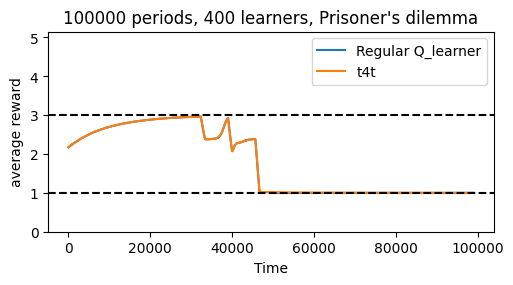

In [323]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='Regular Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='t4t')
plt.title(f"{local_periods} periods, {learners} learners, Prisoner's dilemma")
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("average reward")
plt.axhline(y=3, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.ylim(0,5.15)
plt.legend()
plt.show()

In [307]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [308]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

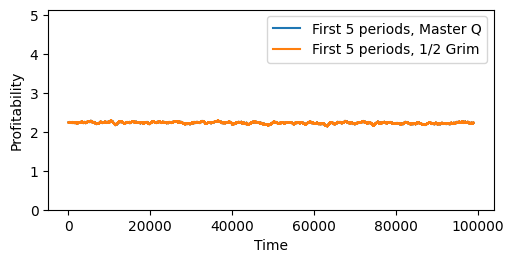

In [311]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, 1/2 Grim')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0.00,5.15)
plt.legend()
plt.show()

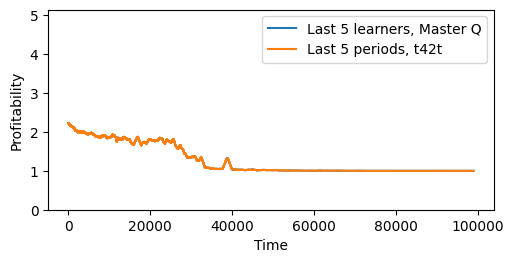

In [312]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 learners, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, t42t')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
plt.ylim(0.00,5.15)
plt.legend()
plt.show()

In [295]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

# ATTEMPTS WITH LONGER PERIODS: #

In [99]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
#200.000 periods: 
local_periods = 200000
learners = 200
#theta = 0.00004605
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2, choices1, choices2 = many_games(options, local_periods, 0.3, 0.0000922, learners ,0.95, final_Q)
final_Q2

run # 1 of  200 runs
run # 2 of  200 runs
run # 3 of  200 runs
run # 4 of  200 runs
run # 5 of  200 runs
run # 6 of  200 runs
run # 7 of  200 runs
run # 8 of  200 runs
run # 9 of  200 runs
run # 10 of  200 runs
run # 11 of  200 runs
run # 12 of  200 runs
run # 13 of  200 runs
run # 14 of  200 runs
run # 15 of  200 runs
run # 16 of  200 runs
run # 17 of  200 runs
run # 18 of  200 runs
run # 19 of  200 runs
run # 20 of  200 runs
run # 21 of  200 runs
run # 22 of  200 runs
run # 23 of  200 runs
run # 24 of  200 runs
run # 25 of  200 runs
run # 26 of  200 runs
run # 27 of  200 runs
run # 28 of  200 runs
run # 29 of  200 runs
run # 30 of  200 runs
run # 31 of  200 runs
run # 32 of  200 runs
run # 33 of  200 runs
run # 34 of  200 runs
run # 35 of  200 runs
run # 36 of  200 runs
run # 37 of  200 runs
run # 38 of  200 runs
run # 39 of  200 runs
run # 40 of  200 runs
run # 41 of  200 runs
run # 42 of  200 runs
run # 43 of  200 runs
run # 44 of  200 runs
run # 45 of  200 runs
run # 46 of  200 ru

array([[[37.46437087, 27.77854005],
        [40.82426436, 27.8909957 ]],

       [[59.63225538, 37.79364582],
        [44.71131882, 57.82815505]],

       [[58.61972148, 35.73549225],
        [50.09486598, 58.65342102]],

       [[59.94512723, 25.16939188],
        [56.90713786, 58.87930755]],

       [[59.9912846 , 28.92229989],
        [51.67747962, 58.80256402]],

       [[59.99994806, 21.12394391],
        [49.80534195, 58.97228793]],

       [[60.        , 20.24153953],
        [44.36895709, 58.59216667]],

       [[60.        , 33.11650309],
        [45.81418636, 57.59651918]],

       [[60.        , 40.85298883],
        [52.03147501, 55.17631284]],

       [[60.        , 56.25497757],
        [57.31384507, 53.3925    ]],

       [[60.        , 54.81909421],
        [57.3925    , 53.3925    ]],

       [[60.        , 43.46417656],
        [57.28544395, 38.17988349]],

       [[60.        , 57.        ],
        [57.3925    , 53.39249998]],

       [[60.        , 57.        ],
  

In [100]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

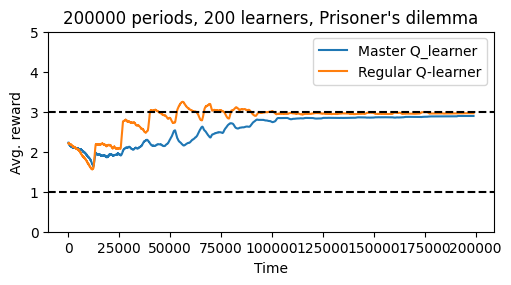

In [101]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,198999)
t_arr2 = np.arange(0,198999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='Master Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular Q-learner')
plt.axhline(y=3, color='k', linestyle = '--')
plt.axhline(y=1, color='k', linestyle = '--')
plt.title(f"{local_periods} periods, {learners} learners, Prisoner's dilemma")
plt.xlabel("Time")
plt.ylabel("Avg. reward")
plt.ylim(0,5)
plt.legend()
plt.show()

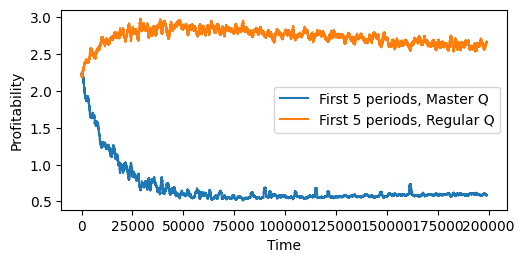

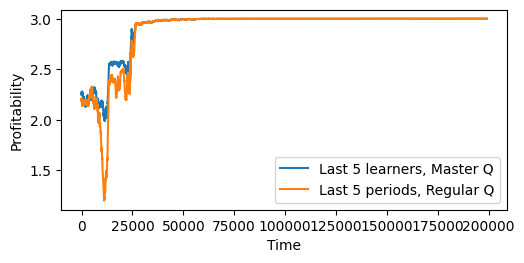

In [102]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,198999)
t_arr2 = np.arange(0,198999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Regular Q')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,198999)
t_arr2 = np.arange(0,198999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 learners, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, Regular Q')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [94]:

Q = np.zeros((10,2,2))

all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(Q, options, 10000, 0.3, 0.000322, 0.95)



TypeError: not enough arguments: expected 7, got 6